In [32]:
import os
from typing import TypedDict, List, Dict, Annotated
import operator
import json

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langgraph.graph import StateGraph, END
from google import genai
from google.genai import types
    

gemini_api_key = os.getenv("GEMINI_API_KEY")
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")
USE_CLAUDE = False

The goal of  our project was if we were able to build an agentic system that could produce books that can be uploaded to Amazon and if we could somewhat automate the process of writing book. I personally have private interest in literature so I really wonder if this is sensible and if it truly makes sense to automate this process. 

The idea of the workflow is simple.  
The user query is taken. 
Then an outline is generated. 
This outline is then used in a loop to generate the individual chapters.
Then the whole book is concatenated and an EPUB generated


Its quite difficult to get the LLM to output longer chains of text. It won't generate a big book in one step and it won't max out its token window easily. 
Another issue is consitency. The LLM is pretty good at writing snippets, but it struggles to keep the book varied. Further it can easily forget if certain things have already happened or not. 
I chose the Gemini Family of models for this reason. They are quite cheap but also have a giant input context window. My hope is that this can mitigate the forgetting of plot points. 
Of course the more tokens you have to put in the more expensive everything becomes.
I also chose to try Anthropics Claude Models, since I had  some money on the API account. Its far more expensive and performs worse on creative writing benchmarks, but I found it to be quite promising

To use this notebook install the environment using conda and then activate it

In [33]:


class BookWriterState(TypedDict):
    """
    Represents the state of our book writing graph.

    Attributes:
        book_topic: The initial high-level topic for the book.
        book_premise: A more detailed premise or summary generated by the LLM.
        book_outline: A dictionary containing the title and a list of chapter titles.
        chapter_index: An index to keep track of the current chapter being written.
        draft_chapters: A list to store the written content of each chapter.
        book_title: The title of the book.
        book_description: A brief description of the book.
        author_name: The name of the author.
        end_writing: A flag to indicate if the writing process is complete.
        error: A field to store any errors that occur.
        book_cover: A field to store the book cover image.
        language: The language in which the book is written.
    """
    book_topic: str
    book_premise: str
    book_outline: Dict
    chapter_index: int
    book_title: str
    book_description: str
    draft_chapters: Annotated[List[str], operator.add]
    error: str
    end_writing: bool
    author_name: str
    book_cover_file_path: str
    language: str





As typical in LangGraph you need to define the individual nodes. We have a node for each task of the writing process. We quickly test the LLM here , just so we know it works

In [34]:
if USE_CLAUDE:
    llm = ChatAnthropic(model="claude-sonnet-4-20250514", api_key=anthropic_api_key, max_tokens=64000)
else:
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.2, max_output_tokens=65536, api_key=gemini_api_key)

response = llm.invoke("Just say 'Hello, World!'")
print(response)
json_parser = JsonOutputParser()
str_parser = StrOutputParser()
BOOK_COVERS = "book_covers"
os.makedirs(BOOK_COVERS, exist_ok=True)
BOOKS = "books"
os.makedirs(BOOKS, exist_ok=True)


def generate_premise_node(state: BookWriterState) -> Dict:
    """Generates a compelling book premise from a high-level topic."""
    print("--- Generating Book Premise ---")
    try:
        print(state["language"])
        prompt = PromptTemplate(
            template="Generate a compelling one-paragraph book premise in {language} based on this topic: {topic}.  Don't use ** or markdown.",
            input_variables=["topic", "language"],
        )
        chain = prompt | llm | str_parser
        print("current book topic:", state["book_topic"])
        try:
            premise = chain.invoke({"topic": state["book_topic"], "language": state["language"]})
        except Exception as e:
            print(f"Error generating premise: {e}")
            print("--Retrying Premise Generation--")
            premise = chain.invoke({"topic": state["book_topic"], "language": state["language"]})
        print(f"Generated Premise: {premise}")
        prompt = PromptTemplate(
            template="Generate a nice title for a book based on this premise: {premise}. Just give me the title in {language}, nothing else. Don't use ** or markdown.",
            input_variables=["premise", "language"],
        )
        title_chain = prompt | llm | str_parser
        try :
            book_title = title_chain.invoke({"premise": premise, "language": state["language"]})
        except Exception as e:
            print(f"Error generating title: {e}")
            print("--Retrying Title Generation--")
            book_title = title_chain.invoke({"premise": premise, "language": state["language"]})
        print(f"Generated Title: {book_title}")
        
        return {"book_premise": premise, "book_title": book_title} 
    except Exception as e:
        return {"error": f"Failed to generate premise: {e}"}
    
def generate_cover_node(state: BookWriterState) -> Dict:
    """
    Generates a book cover image based on the title, the author, and premise.
    """

    try:
        client = genai.Client( api_key=gemini_api_key)

        prompt = f"Generate a book cover image based on this title: {state['book_title']} and premise {state['book_premise']}. The authors name is {state['author_name']}. Make it compelling."

        response = client.models.generate_images(
        model='imagen-4.0-ultra-generate-preview-06-06',
        prompt=prompt,
        config=types.GenerateImagesConfig(
            number_of_images= 1,
        ))
    


        for generated_image in response.generated_images:
            book_cover_file_path = f"{state['book_title']}_cover.jpg"
            cover_path = os.path.join(BOOK_COVERS, book_cover_file_path)
            generated_image.image.save(cover_path)

            print(f"Saved book cover image to: {cover_path}")

        return {"book_cover_file_path": cover_path}
    except Exception as e:
        return {"error": f"Failed to generate book cover: {e}"}

def generate_outline_node(state: BookWriterState) -> Dict:
    """Generates a book outline based on the premise."""
    print("\n--- Generating Book Outline ---")
    try:
        print(f"now creating outline for premise: {state['book_premise']}")
        prompt = PromptTemplate(
            template=" The user wanted a book for the following topic: {topic}. Based on this premise, create a book outline with a title and a list of chapter titles and a  description for each chapter that makes the narrative structure of this chapter clear. Each chapter should follow a 5-part dramatic structure and should be comprised of two parts. (JSON format) use 'title' and 'description' and inside of description use 'part_1' and 'part_2'. Please write it in {language}. Premise: {premise}. Write atleast 15 chapter. Make the description detailed enough so that a 20 page chapter can be written from it.",
            input_variables=["topic", "premise", "language"],
        )
        
        chain = prompt | llm  | str_parser | json_parser
        try:
            outline = chain.invoke({"topic": state["book_topic"], "premise": state["book_premise"], "language": state["language"]})
        except Exception as e:
            print(f"Error generating outline: {e}")
            print("--Retrying Outline Generation--")
            outline = chain.invoke({"topic": state["book_topic"], "premise": state["book_premise"], "language": state["language"]})
        print(f"Created Outline")
        print(f"Outline: {outline}")
        print("--Generated Outline--")
        print(json.dumps(outline, indent=2, ensure_ascii=False))
        print(f"--Amount of Chapters: {len(outline.get('chapters', []))}--")

        
       

        return {"book_outline": outline }
    except Exception as e:
        return {"error": f"Failed to generate outline: {e}"}

def write_chapter_node(state: BookWriterState) -> Dict:
    """Writes the content for a single chapter based on the outline. It uses a two part structure to produce more text."""

    try:
        outline = state["book_outline"]
        chapter_index = state["chapter_index"]
        chapter_title = outline["chapters"][chapter_index]["title"]
        chapter_description_part_1 = outline["chapters"][chapter_index]["description"]["part_1"]
        chapter_description_part_2 = outline["chapters"][chapter_index]["description"]["part_2"]

        prompt = PromptTemplate(
            template="This is the full draft of a book I wrote: {draft_chapters}. You are an expert author and write in {language}. Now please write the first part of  Chapter {chapter_num}: '{chapter_title}' with description: {description}." \
            " The overall book premise is: {premise}. Don't put the chapters index and title in your output. Never use markdown and don't use *. Write a full chapter part so longer than 20 pages." \
            "Please try to be varied in your sentence structure and vocabulary. NEVER REPEAT YOURSELF and don't repeat phrases from the draft.",
            input_variables=["chapter_num", "chapter_title", "premise", "description", "draft_chapters", "language"],
        )
        chain = prompt | llm | str_parser 
        try:
            chapter_content_part_1 = chain.invoke({
            "chapter_num": chapter_index + 1,
            "chapter_title": chapter_title,
            "premise": state["book_premise"],
            "description": chapter_description_part_1,
            "draft_chapters": state["draft_chapters"],
            "language": state["language"]
        })
        except Exception as e:
            print(f"Error generating chapter content part 1: {e}")
            print("--Retrying Chapter Content Part 1 Generation--")
            chapter_content_part_1 = chain.invoke({
                "chapter_num": chapter_index + 1,
                "chapter_title": chapter_title,
                "premise": state["book_premise"],
                "description": chapter_description_part_1,
                "draft_chapters": state["draft_chapters"],
                "language": state["language"]
            })
        print(f"-- successfully created part 1 for chapter {chapter_index + 1} --")
        prompt_part_2 = PromptTemplate(
            template="This is the full draft of a book I wrote: {draft_chapters}. You are an expert author and write in {language}. The first part of the Chapter {chapter_num}: '{chapter_title}' with description: {description_part_1} has already been written : {part_1}.Now write part 2 with  {description_part_2}." \
            " The overall book premise is: {premise}. Don't put the chapters index and title in your output. Never use markdown and don't use *. Write a full chapter part so longer than 20 pages." \
            "Please try to be varied in your sentence structure and vocabulary. NEVER REPEAT YOURSELF and don't repeat phrases from the draft.",
            input_variables=["chapter_num", "chapter_title", "premise", "description_part_1", "draft_chapters", "language"],
        )
        chain = prompt_part_2 | llm | str_parser 
        try:
            chapter_content_part_2 = chain.invoke({
                "chapter_num": chapter_index + 1,
                "chapter_title": chapter_title,
                "premise": state["book_premise"],
                "description_part_1": chapter_description_part_1,
            "description_part_2": chapter_description_part_2,
            "draft_chapters": state["draft_chapters"],
            "language": state["language"],
            "part_1": chapter_content_part_1,
        })
            
        except Exception as e:
            print(f"Error generating chapter content part 2: {e}")
            print("--Retrying Chapter Content Part 2 Generation--")
            chapter_content_part_2 = chain.invoke({
                "chapter_num": chapter_index + 1,
                "chapter_title": chapter_title,
                "premise": state["book_premise"],
                "description_part_1": chapter_description_part_1,
                "description_part_2": chapter_description_part_2,
                "draft_chapters": state["draft_chapters"],
                "language": state["language"],
                "part_1": chapter_content_part_1,
            })
        print(f"-- successfully created part 1 and part 2 for chapter {chapter_index + 1} --")
        chapter_content = {}
        chapter_content['content'] = chapter_content_part_1  + "\n" + chapter_content_part_2
        chapter_content['title'] = chapter_title
       
        return {"draft_chapters": [chapter_content], "chapter_index": chapter_index + 1}
    except Exception as e:
        return {"error": f"Failed to write chapter: {e}"}


def end_writing_node(state: BookWriterState) -> Dict:
    """Finalizes the writing process."""
    print("\n--- Finalizing Writing Process ---")
    try:
        if state["draft_chapters"]:
            print("Writing completed successfully.")
            return { "end_writing": True}
        else:
            return {"error": "No chapters were written.", "end_writing": True}
    except Exception as e:
        return {"error": f"Failed to finalize writing: {e}", "end_writing": True}
    



def write_description_node(state: BookWriterState) -> Dict:
    """
    Writes the book description based on the draft chapters.
    """
    print("\n--- Writing Book Description ---")
    try:
        prompt = PromptTemplate(
            template="This is a book I wrote: {draft_chapters}. It has the title {title}. Please write a compelling description for it, but leave somethings open to the reader. You can use HTML tags to format the description.  Just give me the description in {language}, nothing else.",
            input_variables=["title", "draft_chapters", "language"], 
        )

        formatted_prompt = prompt.format(title=state.get("book_title", "[Untitled Book]"), draft_chapters=state.get("draft_chapters", []), language=state.get("language", "English"))

      

        response = llm.invoke(formatted_prompt)
        

        description = str_parser.invoke(response)
      
        return {"book_description": description}
    except Exception as e:
        return {"error": f"Failed to write description: {e}"}



content='Hello, World!' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--672d9e3f-3d92-4555-972c-29bd874bc3f7-0' usage_metadata={'input_tokens': 8, 'output_tokens': 26, 'total_tokens': 34, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 22}}


We try to encourage the model to write as much as possible. For generating the chapters we therefore let it write each one in two parts, so that it writes more in one chapter.
Of course you could scale this even more if you wanted to. 
At some point every context window will reach its limit though.

This is our only decision function so it get an extra code block

In [35]:

def should_continue_writing(state: BookWriterState) -> str:
    """Checks if there are more chapters to write."""
    print("--- Checking for More Chapters ---")
    next_index = state["chapter_index"]
    
    if next_index < len(state["book_outline"]["chapters"]):
        print(f"{next_index} of {len(state['book_outline']['chapters'])}")
        return "continue_writing"
    else:
       
        return "end_writing"


In [36]:

workflow = StateGraph(BookWriterState)

# Add nodes
workflow.add_node("generate_premise", generate_premise_node)
workflow.add_node("generate_outline", generate_outline_node)
workflow.add_node("write_chapter", write_chapter_node)
workflow.add_node("end_writing", end_writing_node)
workflow.add_node("write_description", write_description_node)
workflow.add_node("generate_cover_node", generate_cover_node)
# Define the flow

workflow.set_entry_point("generate_premise")
workflow.add_edge("generate_premise", "generate_outline")
workflow.add_edge("generate_outline", "generate_cover_node")
workflow.add_edge("generate_cover_node", "write_chapter")


# Add the conditional edge for the chapter writing loop
workflow.add_conditional_edges(
    "write_chapter",
    should_continue_writing,
    {
        "continue_writing": "write_chapter", 
        "end_writing": "write_description"             
    }
)


workflow.add_edge("write_description", "end_writing")  # End the workflow after writing the description

app = workflow.compile(checkpointer=None)



We can see a nice visualization of our graph here : 

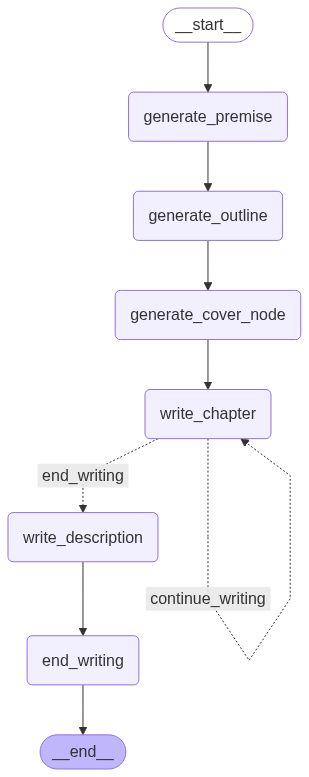

In [37]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:

def run_graph(initial_input):
  
    state = initial_input.copy()
    

    
    output = app.invoke(state)
    if output.get("end_writing"):
            print("Graph finished.")
            return output
      
        
    

print("Please describe the topic of the book I should write:")
input_topic = input().strip()
print("State the authors name:")
author_name = input().strip()
print("State the language of the book:")
language = input().strip().lower()

initial_input = {
    "book_topic": input_topic,
    "chapter_index": 0,
    "draft_chapters": [],
    "author_name": author_name,
    "language": language
}

print("--- Starting Book Writer Graph ---")
final_state = run_graph(initial_input)

print("\n--- Graph Finished ---")
print(f"\nTitle: {final_state.get('book_outline', {}).get('title')}")
print("\nPremise:")
print(final_state.get('book_premise'))
print("\nDraft Chapters:")
for i, chapter in enumerate(final_state.get('draft_chapters', [])):
    print(f"--- Chapter {i+1} ---\n{chapter}\n")
print("\nBook Description:")
print(final_state.get('book_description', 'No description generated.'))
print("\nAuthor Name:")
print(final_state.get('author_name', 'No author name provided.'))
print("\n--- Book Writing Process Completed ---")

Now we have generated our book. We want to format is nicely though so we need to create an EBUP to publish this book.

In [ ]:
from ebooklib import epub



def create_epub(state: BookWriterState, filename: str = "book.epub"):
    """Creates an EPUB file from the book state."""
    book = epub.EpubBook()

    # Set metadata
    book.set_title(state.get("book_title", "Untitled Book"))
    if final_state.get("language") != "english":
        book.set_language(final_state.get("language"))
    else:
        book.set_language("en")
    book.add_author(state.get("author_name", "Unknown Author"))



    # Add cover image
    cover_file_path = state.get("book_cover_file_path", "cover.jpg")
    print(f"Using cover file: {cover_file_path}")
    try:
       book.set_cover(cover_file_path, open(cover_file_path, 'rb').read())

    
    except FileNotFoundError:
        print("⚠️ Cover image 'cover.jpg' not found. Skipping cover.")

    # Add chapters
    draft_chapter = state.get("draft_chapters", [])
    #print(draft_chapter)
    chapter_items = []
    for chapter in draft_chapter:
        
        chapter_title = str(chapter["title"])
        #print(chapter_title)
        chapter_content = str(chapter["content"])
        #print(chapter_content)
        c = epub.EpubHtml(title=chapter_title, file_name=f"{chapter_title}.xhtml", lang="en")
        c.content = f"<h1>{chapter_title}</h1><p>{chapter_content}</p>"
        book.add_item(c)
        chapter_items.append(c)
         

    # Add navigation
    book.add_item(epub.EpubNcx())
    book.add_item(epub.EpubNav())
    book.toc = (
    (epub.Section('Chapters'), tuple(chapter_items)),
)

    book.spine = ['cover', 'nav'] + chapter_items

 
    # Save the EPUB file
    epub.write_epub(filename, book)
    print(f"EPUB file '{filename}' created successfully.")

create_epub(final_state, os.path.join(BOOKS, f"{final_state['book_title']}.epub"))

Using cover file: book_covers/Reutlingen Bloom_cover.jpg
✅ EPUB file 'books/Reutlingen Bloom.epub' created successfully.


# Conclusion
Feel free to read the books I provide in this repo. Some part are definitely fun. The covers look great too and the text is almost always faithfully generated. 
The text quality is okay, but its not really a long book. Increasing the length of the book and stopping repetitions are the most difficult part of this.
I have submitted some books to Amazon. However since approving books can take time, I cannot say wether the books are actually bought by anyone.

A book can be relatively expensive especially with Claude Sonnet , where it costs about more then 4 dollars per book and is also very slow. I would not recommend Claude.
Gemini is significantly cheaper with less around 1 dollar per book, especially when using the flash variant.
Also generating a book can take a long time,  more then 30 minutes, which can affect rate limits. Also, most APIs are not robust  and  sometimes fail in generating something, so often you have to try again and waste ressources.

I would say that the chances of these books selling are relatively low, but I will try anyway.What nice is that I also generate a description right away and it looks good

I also have thought about ways to improve this / make it more profitable. 
Of course the formatting of the book could be more intricate, but I think this is not a big hinderance.

Automatic publishing is something I thought of but since there is no API this is quite cumbersome and is also probably not what Amazon wants to happen. 
Still maybe I will do it in the future. 

An idea would be to add another node using a Wikipedia or Search Engine Query to embbed some extra knowledge about a city ( perhaps using RAG). This could then be used to write local crime stories , a genre that seems to sell well and could be personalized to most cities and even villages.

An idea that might come into conflict with data privacy laws is using pictures of friends to generate a cover with them and book about them. However this could be highly personalized. Another idea is generating books specifically for a user , using information that is collected through various sources. This would require significantly more effort to deploy though

A great strength of this approach is that I can generate books in any language, although quality might vary. 

## Ethical Concerns

People might generate harmful content using this software
People might lose their work through automation in the future
This wastes valuable ressources  for something quite useless
This might be used to flood the web with AI Slop


##  But 
Overall this project was quite useful and I might go back to it later !